In [1]:
import nmp_util
from nmp_util import *

In [2]:
r_sym, phi_sym = sympy.symbols('r, phi')

formula, K = nmp_util.error_propagation_formula(
    [
        r_sym*sympy.cos(phi_sym), 
        r_sym*sympy.sin(phi_sym)
    ], [
        r_sym, 
        phi_sym
    ])

display(formula)

k11, k22 = sympy.symbols('k11, k22')

diagonal_k = sympy.diag([k11,k22], unpack=True)
formula = formula.subs({K:diagonal_k}).doit() #necessary to perform matmul
display(formula)

Matrix([
[cos(phi), -r*sin(phi)],
[sin(phi),  r*cos(phi)]])*K*Matrix([
[   cos(phi),   sin(phi)],
[-r*sin(phi), r*cos(phi)]])

Matrix([
[            k11*cos(phi)**2 + k22*r**2*sin(phi)**2, k11*sin(phi)*cos(phi) - k22*r**2*sin(phi)*cos(phi)],
[k11*sin(phi)*cos(phi) - k22*r**2*sin(phi)*cos(phi),             k11*sin(phi)**2 + k22*r**2*cos(phi)**2]])

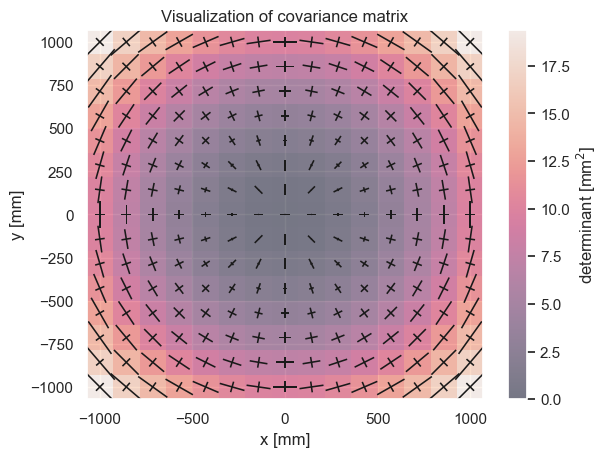

In [3]:
# plot a square meter area
_x = np.linspace(-1000,1000, 15)
_y = np.linspace(-1000,1000, 15)

x, y = np.meshgrid(_x, _y)

# polar coordinates for further calculations
r = np.sqrt(x**2 + y**2)
phi = np.atan2(y, x)

r_cov = 2 # mm
phi_cov = np.deg2rad(1/3600) # 1''

# compute covariances via formula from previous cell
covariances = sympy.lambdify([k11, k22, r_sym, phi_sym], formula)(r_cov, phi_cov,r,phi)

#we need to rotate the axis beacause np.linalg expects a shape (...,m,n)
covariances = np.moveaxis(covariances, [0,1], [2,3])

plt.figure()
plt.title('Visualization of covariance matrix')
nmp_util.matrix_quiver(x, y, covariances, shade_determinant=True)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.show()

In [4]:
campPP_df = nmp_util.read_dat('campPP_mar2024.dat', names = ['r [mm]', 'phi [°]'])
campPP_df.drop(index=[0,1], inplace=True)

campPP_df['phi [°]'] = campPP_df['phi [°]'].astype(float)
campPP_df['r [mm]'] = campPP_df['r [mm]'].astype(float)

display(campPP_df)

c:\Users\cedric\OneDrive\uni\semester_6\nmp\exercises\ex_02\nmp_util.py:77: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return pd.read_csv(*args, index_col=False, sep='\s+', **kwargs)


,r [mm],phi [°]
2,-17.562529,69.866607
3,-5.648522,107.096015
4,-2.265576,133.324216
5,-0.755542,159.877900
6,0.000000,186.508000
7,3.123464,193.456391
8,6.449076,187.695724
9,14.775243,165.330885
10,21.584930,143.266833
11,26.767305,119.367016
